# 載入Python模組

In [1]:
# https://medium.com/mlearning-ai/human-segmentation-using-u-net-with-source-code-easiest-way-f78be6e238f9
import tensorflow as tf
import numpy as np
import re
import os
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import color
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 讀取資料

In [2]:
IMG_HEIGHT = 32
IMG_WIDTH  = 32
IMG_LENGTH = 32
# CHANNELS = 3

training_images_names = os.listdir(r"C:\\Users\\user\\Desktop\\Jupyter\\simp_topology_optimization\\data\\Masks3D_heat\\")
training_masks_names = os.listdir(r"C:\\Users\\user\\Desktop\\Jupyter\\simp_topology_optimization\\data\\Images3D_heat\\")

X = np.zeros((len(training_images_names),IMG_HEIGHT,IMG_WIDTH,IMG_LENGTH,1))
Y = np.zeros((len(training_masks_names),IMG_HEIGHT,IMG_WIDTH,IMG_LENGTH,1))

In [3]:
for i,n in enumerate(training_images_names): # 數據組數900
    img = []
    with open(f'./data/Masks3D_heat/{n}') as f:  # 當開啟一個txt檔時
        for line in f.readlines():           # 30*30行
            st = line.split()                # 去除空格、換行
            for s in st:
                img.append(float(s))         # 新增30個元素
    img2 = np.array(img)
    img2 = img2.reshape(32,32,32,1)
    
    X[i] = img2

for i,n in enumerate(training_masks_names):
    mask = []
    with open(f'./data/Images3D_heat/{n}') as f:
        for line in f.readlines():
            st = line.split()
            for s in st:
                mask.append(float(s))
    mask2 = np.array(mask)
    mask2 = mask2.reshape(32,32,32,1)
    
    Y[i] = mask2
    
X[0].shape

(32, 32, 32, 1)

In [4]:
X.shape

(962, 32, 32, 32, 1)

# 3D U-Net 結構

In [5]:
inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_LENGTH,1))
s = tf.keras.layers.Lambda(lambda x:x/31)(inputs)

#contracting path
c1 = tf.keras.layers.Conv3D(2,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv3D(2,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling3D((2,2,2))(c1)

c2 = tf.keras.layers.Conv3D(4,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv3D(4,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling3D((2,2,2))(c2)


c3 = tf.keras.layers.Conv3D(8,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv3D(8,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling3D((2,2,2))(c3)


c4 = tf.keras.layers.Conv3D(16,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv3D(16,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling3D((2,2,2))(c4)


c5 = tf.keras.layers.Conv3D(32,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5_1 = tf.keras.layers.Conv3D(32,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5_1 = tf.keras.layers.Dropout(0.3)(c5_1)
c5_2 = tf.keras.layers.Conv3D(32,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5_1)
c5_3 = tf.keras.layers.Conv3D(32,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_2)
c5_4 = tf.keras.layers.Conv3D(64,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_3 )
c5_5 = tf.keras.layers.concatenate([c5_1,c5_4])


#expanding path
u4 = tf.keras.layers.Conv3DTranspose(16,(2,2,2),strides=(2,2,2),padding='same')(c5_5)
u4 = tf.keras.layers.concatenate([u4,c4])
u4 = tf.keras.layers.Conv3D(16,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv3D(16,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u3 = tf.keras.layers.Conv3DTranspose(8,(2,2,2),strides=(2,2,2),padding='same')(u4)
u3 = tf.keras.layers.concatenate([u3,c3])
u3 = tf.keras.layers.Conv3D(8,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv3D(8,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)


u2 = tf.keras.layers.Conv3DTranspose(4,(2,2,2),strides=(2,2,2),padding='same')(u3)
u2 = tf.keras.layers.concatenate([u2,c2])
u2 = tf.keras.layers.Conv3D(4,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv3D(4,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)


u1 = tf.keras.layers.Conv3DTranspose(2,(2,2,2),strides=(2,2,2),padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1,c1])
u1 = tf.keras.layers.Conv3D(2,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv3D(2,(3,3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

output = tf.keras.layers.Conv3D(1,(1,1,1),activation='sigmoid')(u1)

model = tf.keras.Model(inputs=[inputs],outputs=[output])
model.compile(optimizer='adam',loss='MeanSquaredError',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 32, 1)]      0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32, 32, 32, 1)        0         ['input_1[0][0]']             
                                                                                                  
 conv3d (Conv3D)             (None, 32, 32, 32, 2)        56        ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 32, 32, 32, 2)        0         ['conv3d[0][0]']              
                                                                                              

                                                                                                  
 conv3d_transpose_2 (Conv3D  (None, 16, 16, 16, 4)        260       ['conv3d_16[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 16, 16, 16, 8)        0         ['conv3d_transpose_2[0][0]',  
 )                                                                   'conv3d_3[0][0]']            
                                                                                                  
 conv3d_17 (Conv3D)          (None, 16, 16, 16, 4)        868       ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8 (Dropout)         (None, 16, 16, 16, 4)        0         ['conv3d_17[0][0]']           
          

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,  Y, test_size=0.1, random_state=42)

In [32]:
results = model.fit(X,Y,batch_size=8,epochs=100)
model.save('models/topo_3D_non-aug_100_heat_v2.h5')

Epoch 1/100
121/121 [==============================] - 28s 213ms/step - loss: 0.1341 - accuracy: 0.3178
Epoch 2/100
121/121 [==============================] - 26s 214ms/step - loss: 0.0914 - accuracy: 0.3186
Epoch 3/100
121/121 [==============================] - 26s 214ms/step - loss: 0.0889 - accuracy: 0.3186
Epoch 4/100
121/121 [==============================] - 26s 213ms/step - loss: 0.0882 - accuracy: 0.3186
Epoch 5/100
121/121 [==============================] - 26s 211ms/step - loss: 0.0878 - accuracy: 0.3186
Epoch 6/100
121/121 [==============================] - 26s 212ms/step - loss: 0.0876 - accuracy: 0.3186
Epoch 7/100
121/121 [==============================] - 26s 212ms/step - loss: 0.0873 - accuracy: 0.3186
Epoch 8/100
121/121 [==============================] - 26s 212ms/step - loss: 0.0871 - accuracy: 0.3186
Epoch 9/100
121/121 [==============================] - 26s 212ms/step - loss: 0.0870 - accuracy: 0.3186
Epoch 10/100
121/121 [==============================] - 26s 211m

121/121 [==============================] - 25s 210ms/step - loss: 0.0849 - accuracy: 0.3320
Epoch 80/100
121/121 [==============================] - 25s 208ms/step - loss: 0.0849 - accuracy: 0.3320
Epoch 81/100
121/121 [==============================] - 25s 209ms/step - loss: 0.0849 - accuracy: 0.3322
Epoch 82/100
121/121 [==============================] - 25s 209ms/step - loss: 0.0849 - accuracy: 0.3322
Epoch 83/100
121/121 [==============================] - 25s 210ms/step - loss: 0.0849 - accuracy: 0.3321
Epoch 84/100
121/121 [==============================] - 26s 211ms/step - loss: 0.0849 - accuracy: 0.3322
Epoch 85/100
121/121 [==============================] - 25s 210ms/step - loss: 0.0849 - accuracy: 0.3321
Epoch 86/100
121/121 [==============================] - 25s 210ms/step - loss: 0.0849 - accuracy: 0.3322
Epoch 87/100
121/121 [==============================] - 25s 210ms/step - loss: 0.0849 - accuracy: 0.3321
Epoch 88/100
121/121 [==============================] - 25s 210ms/st

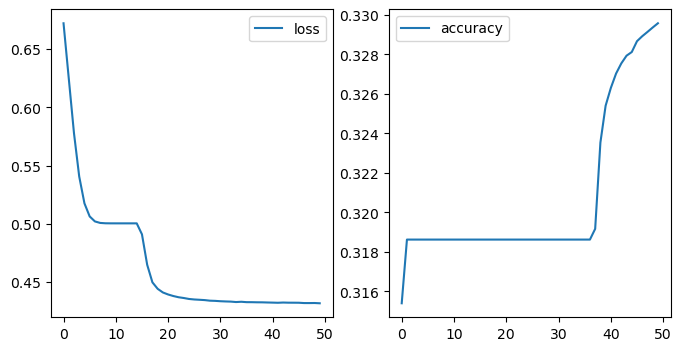

In [11]:
fig,(a1,a2) = plt.subplots(1,2,figsize=(8,4))
a1.plot(np.arange(0,50),results.history['loss'],label = 'loss')
a2.plot(np.arange(0,50),results.history['accuracy'],label='accuracy')
a1.legend()
a2.legend()

# 定義繪圖函式

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

def display_3D_Image(rho):
    nely, nelx, nelz, channel = rho.shape
    hx, hy, hz = 1, 1, 1  # User-defined unit element size
    face = np.array([[0, 1, 2, 3], [1, 5, 6, 2], [3, 2, 6, 7], [0, 4, 7, 3], [0, 1, 5, 4], [4, 5, 6, 7]])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for k in range(nelz):
        z = (k - 1) * hz
        for i in range(nelx):
            x = (i - 1) * hx
            for j in range(nely):
                y = nely * hy - (j - 1) * hy
                if rho[j, i, k] > 0.5:  # User-defined display density threshold
                    xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
                    yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
                    zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
                    vert = list(zip(xp, yp, zp))
                    vert = np.array(vert)
                    # vert[:, [1, 2]] = vert[:, [2, 1]]
                    # vert[:, 1, :] = -vert[:, 1, :]
                    poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
                    ax.add_collection3d(Poly3DCollection(poly3d, facecolors=[0.2 + 0.8 * (1 - rho[j, i, k, 0]),
                                                                             0.2 + 0.8 * (1 - rho[j, i, k, 0]),
                                                                             0.2 + 0.8 * (1 - rho[j, i, k, 0])],
                                                             linewidths=1, alpha=0.25)) # , edgecolors='r'

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(0, nely+1)
    ax.set_ylim(0, nelx+1)
    ax.set_zlim(0, nelz+1)
    ax.set_title('ISO display')
    ax.view_init(30, 30)
    plt.show()


# Example usage:
# Assuming you have a 3D numpy array 'rho', you can call the function as follows:
# display_3D(rho)

In [13]:
def display_3D_Mask(rho):
    nely, nelx, nelz, channel = rho.shape
    hx, hy, hz = 1, 1, 1  # User-defined unit element size
    face = np.array([[0, 1, 2, 3], [1, 5, 6, 2], [3, 2, 6, 7], [0, 4, 7, 3], [0, 1, 5, 4], [4, 5, 6, 7]])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for k in range(nelz):
        z = (k - 1) * hz
        for i in range(nelx):
            x = (i - 1) * hx
            for j in range(nely):
                y = nely * hy - (j - 1) * hy
                if rho[j, i, k] == 1.0:  # User-defined display density threshold
                    xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
                    yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
                    zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
                    vert = list(zip(xp, yp, zp))
                    vert = np.array(vert)
                    # vert[:, [1, 2]] = vert[:, [2, 1]]
                    # vert[:, 1, :] = -vert[:, 1, :]
                    poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
                    ax.add_collection3d(Poly3DCollection(poly3d, facecolors='blue',
                                                             linewidths=1, alpha=0.1)) # , edgecolors='r'
                elif rho[j, i, k] == 0.0:
                    xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
                    yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
                    zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
                    vert = list(zip(xp, yp, zp))
                    vert = np.array(vert)
                    # vert[:, [1, 2]] = vert[:, [2, 1]]
                    # vert[:, 1, :] = -vert[:, 1, :]
                    poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
                    ax.add_collection3d(Poly3DCollection(poly3d, facecolors='red',
                                                             linewidths=1, alpha=1.0)) # , edgecolors='r'
#                 else:
#                     xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
#                     yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
#                     zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
#                     vert = list(zip(xp, yp, zp))
#                     vert = np.array(vert)
#                     # vert[:, [1, 2]] = vert[:, [2, 1]]
#                     # vert[:, 1, :] = -vert[:, 1, :]
#                     poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
#                     ax.add_collection3d(Poly3DCollection(poly3d, facecolors='white',
#                                                              linewidths=1, alpha=0.05)) # , edgecolors='r'

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(0, nely+1)
    ax.set_ylim(0, nelx+1)
    ax.set_zlim(0, nelz+1)
    ax.set_title('ISO display')
    ax.view_init(30, 30)
    plt.show()


# Example usage:
# Assuming you have a 3D numpy array 'rho', you can call the function as follows:
# display_3D(rho)

In [14]:
model = tf.keras.models.load_model('models/topo_3D_non-aug_100_heat_v2.h5')

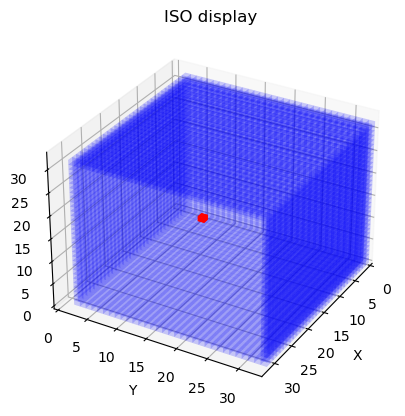

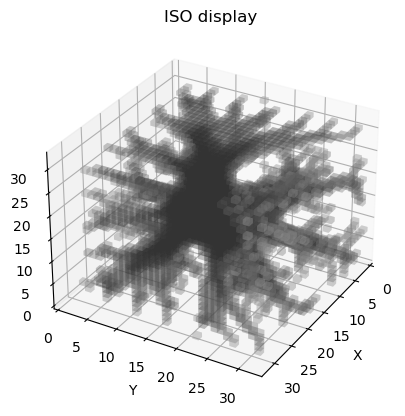

1/1 [==============================] - 0s 206ms/step


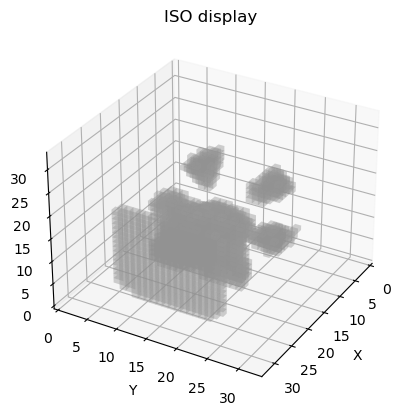

In [15]:
k=np.random.randint(0,len(X_test))
# fig,(a1,a2) = plt.subplots(1,2)

# a1.imshow(X_test[k])
display_3D_Mask(X_test[k])
display_3D_Image(y_test[k])

(h,w,l,c) = X_test[k].shape
i = X_test[k].reshape((1,h,w,l,c))

pred = model.predict(i)

# a2.imshow(pred.reshape(pred.shape[1:-1]),cmap='gray')
display_3D_Image(pred.reshape(pred.shape[1:]))

# GUI

In [16]:
import tkinter as tk
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.figure import Figure
import matplotlib.animation as animation

window = tk.Tk()
window.title("Fast Topology Optimization")
window.geometry("800x550+250+150")
mask = Figure(figsize=(4, 4), dpi=100)
ax1 = mask.add_subplot(111, projection='3d')
image = Figure(figsize=(4, 4), dpi=100)
ax2 = image.add_subplot(111, projection='3d')

# pltdata = None
# colorbar = None
# colorbar = f.colorbar(pltdata, ax=ax4, pad=0.1)

def calc():
    ax1.clear()
    # r=np.random.randint(0,len(X_test))
    r=p.get()+30*(v.get()-1)-1
    nely, nelx, nelz, channel = X[r].shape
    hx, hy, hz = 1, 1, 1  # User-defined unit element size
    face = np.array([[0, 1, 2, 3], [1, 5, 6, 2], [3, 2, 6, 7], [0, 4, 7, 3], [0, 1, 5, 4], [4, 5, 6, 7]])

    for k in range(nelz):
        z = (k - 1) * hz
        for i in range(nelx):
            x = (i - 1) * hx
            for j in range(nely):
                y = nely * hy - (j - 1) * hy
                if X[r][j, i, k] == 1.0:  # User-defined display density threshold
                    xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
                    yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
                    zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
                    vert = list(zip(xp, yp, zp))
                    vert = np.array(vert)
                    # vert[:, [1, 2]] = vert[:, [2, 1]]
                    # vert[:, 1, :] = -vert[:, 1, :]
                    poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
                    ax1.add_collection3d(Poly3DCollection(poly3d, facecolors='blue',
                                                             linewidths=1, alpha=0.05)) # , edgecolors='r'
                elif X[r][j, i, k] == 0.0:
                    xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
                    yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
                    zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
                    vert = list(zip(xp, yp, zp))
                    vert = np.array(vert)
                    # vert[:, [1, 2]] = vert[:, [2, 1]]
                    # vert[:, 1, :] = -vert[:, 1, :]
                    poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
                    ax1.add_collection3d(Poly3DCollection(poly3d, facecolors='red',
                                                             linewidths=1, alpha=1.0)) # , edgecolors='r'
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim(0, nely+1)
    ax1.set_ylim(0, nelx+1)
    ax1.set_zlim(0, nelz+1)
    ax1.set_title('Boundary Condition')
    ax1.view_init(30, 30)
    canvas_mask.draw()
    
    ax2.clear()
    nely, nelx, nelz, channel = Y[r].shape
    for k in range(nelz):
        z = (k - 1) * hz
        for i in range(nelx):
            x = (i - 1) * hx
            for j in range(nely):
                y = nely * hy - (j - 1) * hy
                if Y[r][j, i, k] > 0.5:  # User-defined display density threshold
                    xp = [x, x, x+hx, x+hx, x, x, x+hx, x+hx]
                    yp = [y, y-hy, y-hy, y, y, y-hy, y-hy, y]
                    zp = [z, z, z, z, z+hz, z+hz, z+hz, z+hz]
                    vert = list(zip(xp, yp, zp))
                    vert = np.array(vert)
                    # vert[:, [1, 2]] = vert[:, [2, 1]]
                    # vert[:, 1, :] = -vert[:, 1, :]
                    poly3d = [[vert[face[ix][iy]] for iy in range(len(face[0]))] for ix in range(len(face))]
                    ax2.add_collection3d(Poly3DCollection(poly3d, facecolors=[0.2 + 0.8 * (1 - Y[r][j, i, k, 0]),
                                                                              0.2 + 0.8 * (1 - Y[r][j, i, k, 0]),
                                                                              0.2 + 0.8 * (1 - Y[r][j, i, k, 0])],
                                                             linewidths=1, alpha=0.25)) # , edgecolors='r'

    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_xlim(0, nely+1)
    ax2.set_ylim(0, nelx+1)
    ax2.set_zlim(0, nelz+1)
    ax2.set_title('SIMP Topology Optimization')
    ax2.view_init(30, 30)
    canvas_image.draw()

# 輸入欄位&文字
label_p = tk.Label(window, text = "Load X coordinate")
label_p.grid(row=0, column=0)
p = tk.IntVar()
entry_p = tk.Entry(window, textvariable=p, width = 20)
entry_p.grid(row=0, column=1)
label_v = tk.Label(window, text = "Load Y coordinate")
label_v.grid(row=1, column=0)
v = tk.IntVar()
entry_v = tk.Entry(window, textvariable=v, width = 20)
entry_v.grid(row=1, column=1)
label_Hd = tk.Label(window, text = "Load Z coordinate")
label_Hd.grid(row=2, column=0)
Hd = tk.IntVar()
entry_Hd = tk.Entry(window, textvariable=Hd, width = 20)
entry_Hd.grid(row=2, column=1)
label_PT = tk.Label(window, text = "Volume Fraction")
label_PT.grid(row=3, column=0)
PT = tk.DoubleVar()
entry_PT = tk.Entry(window, textvariable=PT, width = 20)
entry_PT.grid(row=3, column=1)
label_t = tk.Label(window, text = "Penalization")
label_t.grid(row=4, column=0)
t = tk.DoubleVar()
entry_t = tk.Entry(window, textvariable=t, width = 20)
entry_t.grid(row=4, column=1)

# 按鈕與選單
button = tk.Button(window, text = "Calculate", command=calc)
button.grid(row=5, column=0)

# # 将绘制的图形显示到tkinter:创建属于root的canvas画布,并将图f置于画布上
canvas_mask = FigureCanvasTkAgg(mask, master=window)
canvas_mask.draw()
canvas_mask.get_tk_widget().grid(row=6, column=0, columnspan=2)
canvas_image = FigureCanvasTkAgg(image, master=window)
canvas_image.draw()
canvas_image.get_tk_widget().grid(row=6, column=2, columnspan=2)

toolbar_frame = tk.Frame(window)
toolbar = NavigationToolbar2Tk(canvas_image, toolbar_frame)
toolbar.update()
toolbar.pack(side=tk.BOTTOM)


def _quit():
    """点击退出按钮时调用这个函数"""
    window.quit()  # 结束主循环
    window.destroy()  # 销毁窗口


# 创建一个按钮,并把上面那个函数绑定过来
button = tk.Button(window, text="quit", command=_quit)
# 按钮放在下边
button.grid(row=5, column=1)


window.mainloop()